In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_predict

from statsmodels.stats.contingency_tables import mcnemar

from utilsPlots import *


/opt/homebrew/Caskroom/miniforge/base/envs/opensim-nmd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datadir = Path('../../datadir')

figdir = Path('./figs')
figdir.mkdir(exist_ok=True, parents=True)


In [3]:
df_info = pd.read_csv(datadir / 'participant_info.csv')
df_feat = pd.read_csv(datadir / 'video_features.csv')
df_all = df_info.merge(df_feat, on=['ID', 'day'])

df_feat_key = pd.read_csv(datadir / 'feature_key.csv')
oc_feats = df_feat_key.feature_code.values.tolist()

tft_feats = ['tft_10mwrt', 'tft_10mwt', 'tft_5xsts', 'tft_tug']

run_feats = [x for x in oc_feats if x.startswith('10mwrt_')]
walk_feats = [x for x in oc_feats if x.startswith('10mwt_')]
sts_feats = [x for x in oc_feats if x.startswith('5xsts_')]
tug_feats = [x for x in oc_feats if x.startswith('tug_cone_')]
arm_feats = [x for x in oc_feats if x.startswith('brooke_') 
                                 or x.startswith('arm_rom_')
                                 or x.startswith('curls_')]


In [4]:
feat_map = [
    (
    dict(name='Video (All Tasks)', feats=oc_feats),
    dict(name='All TFTs + Brooke',
         feats = run_feats + walk_feats + sts_feats + tug_feats + ['brooke_score']    
        ),
    dict(name='All TFTs', feats=tft_feats),
    ),
    
    (
    dict(name='Run Video', feats=run_feats),
    dict(name='Run TFT', feats=['tft_10mwrt']),
    ),
    
    (
    dict(name='Walk Video', feats=walk_feats),
    dict(name='Walk TFT', feats=['tft_10mwt']),
    ),
    
    (
    dict(name='TUG Video', feats=tug_feats),
    dict(name='TUG TFT', feats=['tft_tug']),
    ),
    
    (
    dict(name='5xSTS Video', feats=sts_feats),
    dict(name='5xSTS TFT', feats=['tft_5xsts']),
    ),
    
    (
    dict(name='Upper Limb Video',
         feats=arm_feats),
    dict(name='Brooke Video',
         feats=[x for x in oc_feats if x.startswith('brooke_')]),
    dict(name='Brooke', feats=['brooke_score']),
    ),
    
    (
    dict(name='Calves Video',
         feats=[x for x in oc_feats if x.startswith('toe_stand_')]),
    ),
    
    (
    dict(name='Jump Video',
         feats=[x for x in oc_feats if x.startswith('jump_')]),
    )
]


In [5]:
def loso_svc_rbf_cv(df, feats, label, probs=False):
    p_grid = {'svc__C': np.logspace(-1, 2, 8)}

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(random_state=0, probability=True))
    ])
    
    inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=0)
    outer_cv = LeaveOneGroupOut()
    
    X = df[feats].values
    y = df[label].values
    groups = df.ID.values
    
    clf = GridSearchCV(estimator=model, param_grid=p_grid,
                       cv=inner_cv)
    preds = cross_val_predict(clf, X=X, y=y, cv=outer_cv,
                              method=('predict_proba' if probs else 'predict'),
                              groups=groups, n_jobs=-1)
    df_res = df.copy()
    df_res['pred'] = preds[:,1] if probs else preds 
    
    return df_res


In [6]:
def run_mcnemar_test(df_a, df_b, label, score='pred'):
    a_correct = df_a[label] == df_a[score]
    b_correct = df_b[label] == df_b[score]
    
    a_and_b = (a_correct & b_correct).sum()
    a_not_b = (a_correct & ~b_correct).sum()
    b_not_a = (~a_correct & b_correct).sum()
    not_a_not_b = (~a_correct & ~b_correct).sum()
    
    ctable = [[a_and_b, a_not_b],
              [b_not_a, not_a_not_b]]
    
    res = mcnemar(ctable)
    return res.pvalue, a_not_b, b_not_a, res.statistic
    

In [7]:
def plot_ci_analysis(data, yticks=[0, 0.5, 1], figsize=(6,4),
                     title=None, saveto=None, adjusted=False):

    plt.figure(figsize=figsize)
    xticks, xlabels = [], []
    yvals = []
    i = 0
    j = 0
    for group in feat_map:
        for row in group:
            name = row['name']
    
            color = cp[0]
            if 'TFT' in name or name=='Brooke':
                color = '#999999'

            df_res = data[i]['res']
            x = - i - j
            y = balanced_accuracy_score(df_res[label], df_res['pred'],
                                        adjusted=adjusted)
            plt.barh(y=x, height=0.75, width=y, color=color)
            xticks.append(x)
            xlabels.append(name)
            yvals.append(y)
            print(f'{name}\tbalanced accuracy = {y:0.5f}')

            i += 1
        j += 1

    for group in feat_map:
        for a in range(len(group)):
            for b in range(a+1, len(group)):
                namea = group[a]['name']
                nameb = group[b]['name']
                assert namea in xlabels
                assert nameb in xlabels
                idx_a = np.argmax([x==namea for x in xlabels])
                idx_b = np.argmax([x==nameb for x in xlabels])
                df_a = data[idx_a]['res']
                df_b = data[idx_b]['res']
        
                pval, a_not_b, b_not_a, stat = run_mcnemar_test(df_a, df_b, label)
                if pval < 0.001:
                    stars = '***'
                elif pval < 0.01:
                    stars = '**'
                elif pval < 0.05:
                    stars = '*'
                else:
                    stars = ''
                print(f'{stars}\tp={pval:0.5f} ({a_not_b} vs. {b_not_a}) \t {namea} - {nameb}')
                if stars:
                    y = max([yvals[idx_a], yvals[idx_b]]) + 0.05
                    xa, xb = xticks[idx_a], xticks[idx_b]
                    plt.plot([y, y], [xa, xb], c='k', lw=1)
                    plt.text(y, (xa+xb)/2, stars, ha='left', va='center', rotation=90)

    sns.despine(right=False, top=False)
    plt.gca().tick_params(axis=u'both', which=u'both',length=0)
    for y in yticks[1:-1]:
        plt.axvline(y, lw=1, c='#808080', zorder=-3)
    plt.xlim(yticks[0], yticks[-1])
    plt.ylim(min(xticks)-1.5, max(xticks)+1.5)
    plt.xticks(yticks)
    plt.yticks(xticks, xlabels)
    plt.xlabel('Balanced Accuracy')
    plt.title(title)
    plt.tight_layout()
    if saveto:
        plt.savefig(figdir/saveto)
    plt.show()


In [8]:
df = df_all[df_all.type.isin(['FSHD', 'DM'])].copy()
df['is_fshd'] = df.type=='FSHD'
label = 'is_fshd'

data = []
for group in tqdm(feat_map, leave=False):
    feats = set(sum([x['feats'] for x in group], []))    
    for row in group:
        name, feats = row['name'], row['feats']
        df_res = loso_svc_rbf_cv(df, feats, label)
        data.append(dict(name=name, res=df_res))


Video (All Tasks)	balanced accuracy = 0.81109
All TFTs + Brooke	balanced accuracy = 0.76823
All TFTs	balanced accuracy = 0.49342
Run Video	balanced accuracy = 0.74079
Run TFT	balanced accuracy = 0.48684
Walk Video	balanced accuracy = 0.51447
Walk TFT	balanced accuracy = 0.50000
TUG Video	balanced accuracy = 0.46711
TUG TFT	balanced accuracy = 0.50000
5xSTS Video	balanced accuracy = 0.49342
5xSTS TFT	balanced accuracy = 0.50883
Upper Limb Video	balanced accuracy = 0.73308
Brooke Video	balanced accuracy = 0.75508
Brooke	balanced accuracy = 0.63985
Calves Video	balanced accuracy = 0.48026
Jump Video	balanced accuracy = 0.47368
	p=0.64761 (11 vs. 8) 	 Video (All Tasks) - All TFTs + Brooke
**	p=0.00132 (26 vs. 7) 	 Video (All Tasks) - All TFTs
**	p=0.00372 (22 vs. 6) 	 All TFTs + Brooke - All TFTs
*	p=0.02006 (23 vs. 9) 	 Run Video - Run TFT
	p=0.26318 (7 vs. 13) 	 Walk Video - Walk TFT
	p=0.06250 (0 vs. 5) 	 TUG Video - TUG TFT
	p=1.00000 (2 vs. 2) 	 5xSTS Video - 5xSTS TFT
	p=1.00000 (3 v

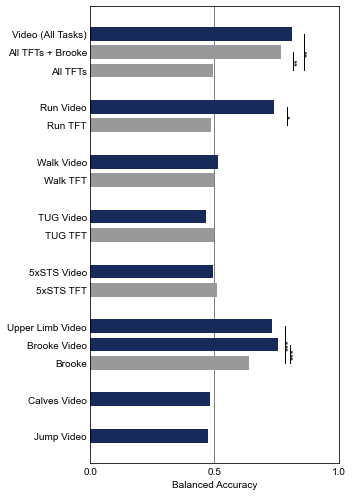

In [9]:
plot_ci_analysis(data, yticks=[0, 0.5, 1], figsize=(5,7), adjusted=False,
                 saveto='fig4_mcnemar.pdf')
